In [1]:
!pip install colab-xterm
%load_ext colabxterm
%xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 5.7 MB/s eta 0:00:00


Launching Xterm...

<IPython.core.display.Javascript object>

# Embedding Model Comparison for RAG Systems

This notebook evaluates and compares different embedding models for Retrieval-Augmented Generation (RAG) systems. We analyze performance metrics like embedding generation time, query response time, and relevance of retrieved documents across different embedding models.

## Models Compared
- Llama 3.2 (4096 dimensions)
- Nomic Embed (768 dimensions)
- BGE-M3 (1024 dimensions)

## Process Overview
1. Load and preprocess documents
2. Configure embedding models
3. Run test queries
4. Evaluate and visualize performance metrics

In [2]:
# Install required dependencies
%pip install langchain langchain_community langchain_ollama langchain_text_splitters langchain_huggingface sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

## Setup and Dependencies

Import all required libraries for document loading, text splitting, embedding generation, evaluation, and visualization.

In [3]:
# Import all necessary libraries
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

# Langchain imports
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_ollama import OllamaEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

# Configure plot settings
plt.rcParams.update({'font.size': 14})

## Document Loading and Processing

Load text documents from a directory and split them into smaller, context-specific chunks for embedding and retrieval.

In [5]:
# Load all text files from the specified directory
# folder_path = "/workspaces/RAG_BOT/2. EmbeddingCompairsion/sampledata"  # Change as needed
folder_path = "/content/sampledata"  # Change as needed
document_loader = DirectoryLoader(folder_path, glob="**/*.txt", loader_cls=TextLoader)
raw_documents = document_loader.load()

print(f"Number of documents loaded: {len(raw_documents)}")
print("Documents loaded:")
print(raw_documents)

Number of documents loaded: 1
Documents loaded:
[Document(metadata={'source': '/content/sampledata/PolicyMangement.txt'}, page_content='ENDPOINT: Delete authentication profile\nPATH: /AuthProfile/DeleteProfile\nMETHOD: POST\nTAGS: Authentication Profile\nMETADATA:\n  * x-idap-anon: False\n  * x-codegen-request-body-name: payload\nPARAMETERS:\n  * uuid (query, Required): Authentication UUID.\nREQUEST BODY: Required\n  Content Type: application/json\n  Schema Properties:\n    * uuid (string): The authentication profile uuid either passed in by method call or as part of the payload.\n    Required fields: uuid\n  Sample Request JSON:\n  ```json\n  {\n  "uuid": "string_value"\n}\n  ```\nRESPONSES:\n  Status Code: 200\n  Description: API-Result\n  Content Type: */*\n  Response Schema: AuthProfileDeleteProfile\n  Response Body Properties:\n    * Result (boolean): Success or failure of the delete\n    * Error (object): Error message text on failure, may be null\n  Sample Response JSON:\n  ```j

In [6]:
# Split each raw document based on dashed line and create sub-documents
split_documents = []
for doc in raw_documents:
    # Use regex to split based on dashed lines like '-----...'
    parts = re.split(r'-{5,}', doc.page_content)
    for i, part in enumerate(parts):
        cleaned_part = part.strip()
        if cleaned_part:
            split_documents.append(
                Document(
                    page_content=cleaned_part,
                    metadata={"source": doc.metadata["source"], "part": i + 1}
                )
            )

print(f"Total split chunks: {len(split_documents)}")

# Prepare documents with consistent metadata for embedding
documents = [
    Document(
        page_content=chunk.page_content,
        metadata=chunk.metadata
    ) for chunk in split_documents
]

Total split chunks: 9


## Embedding Models Configuration

Configure different embedding models with their respective dimensions for comparative evaluation.

In [7]:
# Set up embedding models with dimensions noted
embedding_models = {
    "Llama 3.2": {
        "model": OllamaEmbeddings(model="llama3.2:latest", base_url="http://localhost:11434"),
        "dimensions": 4096
    },
    "Nomic": {
        "model": OllamaEmbeddings(model="nomic-embed-text:latest", base_url="http://localhost:11434"),
        "dimensions": 768
    },
    "BGE-M3": {
        "model": OllamaEmbeddings(model="bge-m3:567m", base_url="http://localhost:11434"),
        "dimensions": 1024
    }
}

## Test Queries Setup

Define test queries to evaluate the performance of different embedding models. These queries will be used to test retrieval effectiveness.

In [8]:
# Define test queries with known relevant document IDs (if available)
test_queries = [
    {"query": "how to get a policy?", "relevant_docs": []},  # Add document IDs if you know ground truth
    {"query": "What is request body needed for https://{tenant_url}/Policy/SavePolicyBlock3", "relevant_docs": []},
    {"query": "delete a policy", "relevant_docs": []}
]

## Evaluation Function

Define a function to evaluate embedding models by measuring:
1. Embedding generation time
2. Query response time
3. Relevance of retrieved documents
4. Overall performance metrics

In [9]:
def evaluate_embedding_model(model_name, embedding_model, documents, test_queries, k=5):
    # Time the embedding creation
    start_time = time.time()
    vector_store = InMemoryVectorStore.from_documents(documents, embedding_model)
    embedding_time = time.time() - start_time

    results = []
    model_metrics = {
        "model": model_name,
        "embedding_time": embedding_time,
        "doc_count": len(vector_store.store),
        "queries": []
    }

    # Test each query
    for test_case in test_queries:
        query = test_case["query"]
        print(f"\nQuery: '{query}'")

        # Time the query execution
        start_time = time.time()
        search_results = vector_store.similarity_search_with_score(query, k=k)
        query_time = time.time() - start_time

        # Extract results and scores
        retrieved_docs = []
        for i, (doc, score) in enumerate(search_results, start=1):
            doc_id = f"{doc.metadata.get('source', 'unknown')}:{doc.metadata.get('part', 'unknown')}"
            retrieved_docs.append({
                "rank": i,
                "doc_id": doc_id,
                "score": score,
                "content": doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content
            })
            print(f"  Result {i} (Score: {score}):")
            print(f"  {doc.page_content[:150]}...")
            print(f"  {'-' * 40}")

            # Add to full results for dataframe
            results.append({
                "model": model_name,
                "query": query,
                "rank": i,
                "score": score,
                "doc_id": doc_id,
                "content": doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content,
                "query_time": query_time
            })

        # Calculate metrics for this query
        query_metrics = {
            "query": query,
            "query_time": query_time,
            "top_score": search_results[0][1] if search_results else None,
            "retrieved_docs": retrieved_docs
        }
        model_metrics["queries"].append(query_metrics)

    return results, model_metrics

## Running Model Evaluations

Execute evaluations on all embedding models and gather performance metrics.

In [10]:
# Run evaluation
all_results = []
all_metrics = []

for model_name, model_info in embedding_models.items():
    print(f"\n=== Evaluating {model_name} (Dimensions: {model_info['dimensions']}) ===")
    results, metrics = evaluate_embedding_model(
        model_name,
        model_info["model"],
        documents,
        test_queries
    )
    all_results.extend(results)
    all_metrics.append(metrics)

# Create DataFrame for analysis
results_df = pd.DataFrame(all_results)

# Performance Summary Table
performance_summary = []
for metrics in all_metrics:
    model_summary = {
        "model": metrics["model"],
        "embedding_time": f"{metrics['embedding_time']:.2f}s",
        "dimensions": embedding_models[metrics["model"]]["dimensions"]
    }

    # Add query-specific metrics
    for q_idx, query_metrics in enumerate(metrics["queries"]):
        query_name = f"q{q_idx+1}"
        model_summary[f"{query_name}_time"] = f"{query_metrics['query_time']:.2f}s"
        model_summary[f"{query_name}_top_score"] = f"{query_metrics['top_score']:.4f}"

    performance_summary.append(model_summary)

# Display performance summary
print("\n=== PERFORMANCE SUMMARY ===")
summary_df = pd.DataFrame(performance_summary)
print(summary_df)


=== Evaluating Llama 3.2 (Dimensions: 4096) ===

Query: 'how to get a policy?'
  Result 1 (Score: 0.08396153637334014):
  ENDPOINT: Gets authentication assurance level
PATH: /AuthProfile/GetProfileMFAScoring
METHOD: POST
TAGS: Authentication Profile
METADATA:
  * x-idap-a...
  ----------------------------------------
  Result 2 (Score: 0.07931652788167809):
  ENDPOINT: Set policy
PATH: /Policy/SavePolicyBlock3
METHOD: POST
TAGS: Policy Management
DESCRIPTION: Replaces and deprecates SavePolicyBlock2, by add...
  ----------------------------------------
  Result 3 (Score: 0.07222695040433114):
  ENDPOINT: Delete policy
PATH: /Policy/DeletePolicyBlock
METHOD: POST
TAGS: Policy Management
METADATA:
  * x-idap-anon: False
  * x-codegen-request-bo...
  ----------------------------------------
  Result 4 (Score: 0.0703107018966429):
  ENDPOINT: Get policy block
PATH: /Policy/GetPolicyBlock
METHOD: POST
TAGS: Policy Management
METADATA:
  * x-idap-anon: False
PARAMETERS:
  * name (qu...
  --

## Results Visualization

Create comprehensive visualizations to compare embedding model performance:
1. Score distribution by model
2. Query time comparison
3. Top scores by query and model
4. Correlation between embedding dimensions and performance
5. Side-by-side model performance comparison

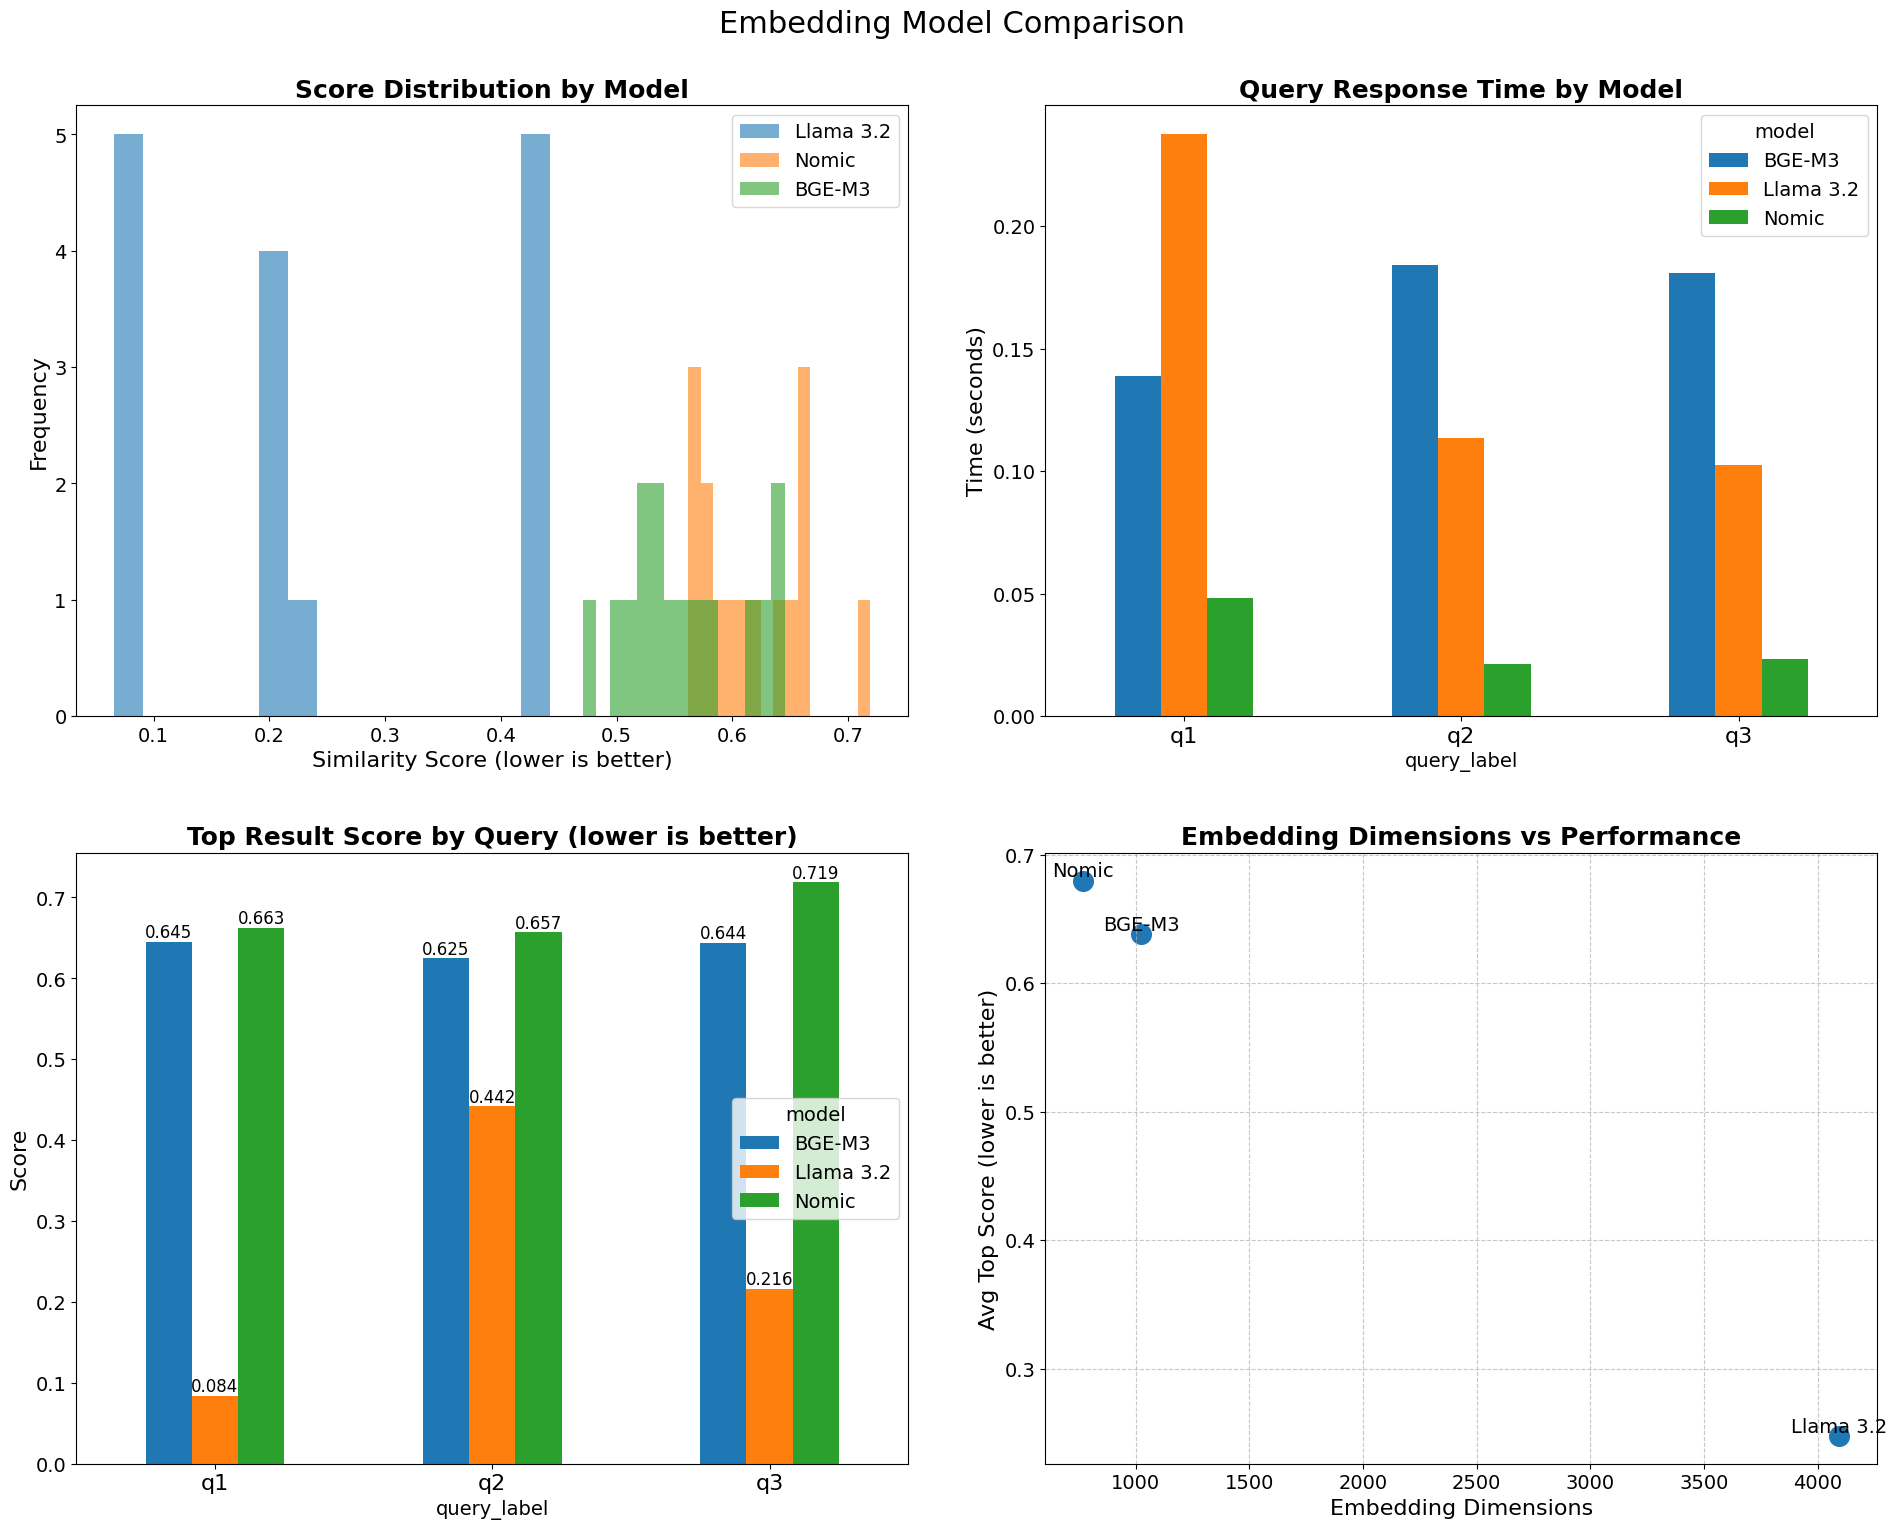

<Figure size 1500x600 with 0 Axes>

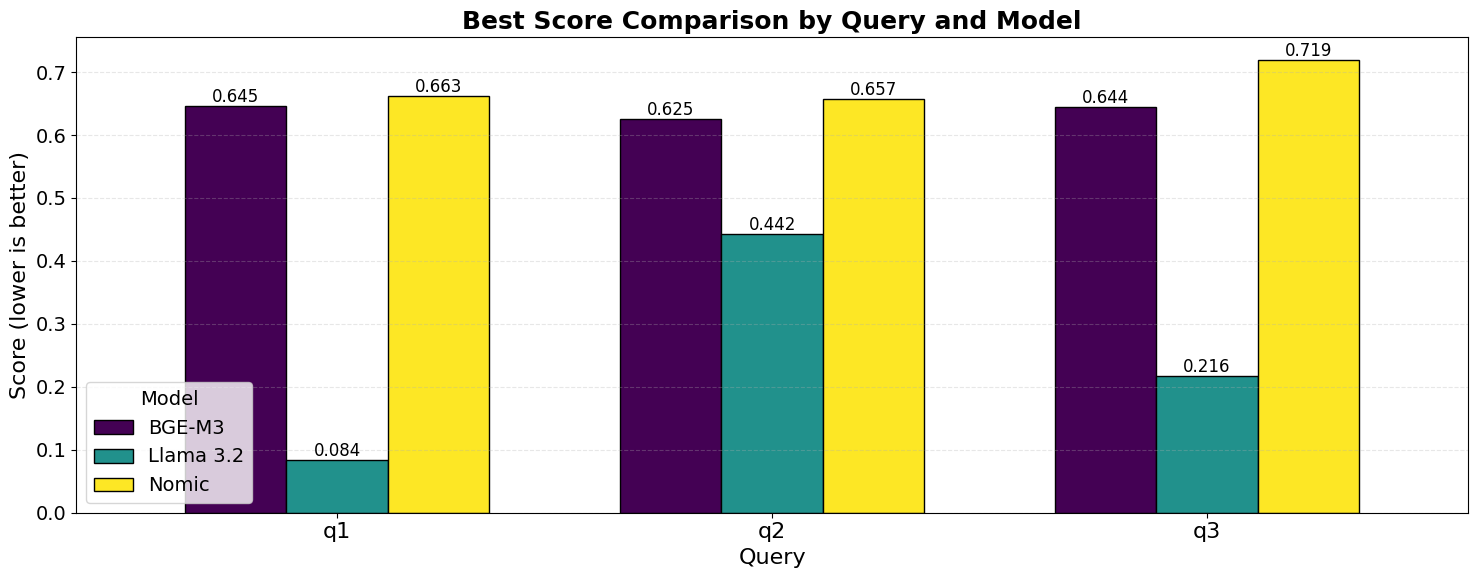

In [11]:
# Create a mapping of queries to shorter labels
query_labels = {}
for i, q in enumerate([q['query'] for q in test_queries]):
    query_labels[q] = f'q{i+1}'

# Convert DataFrame to use query labels instead of full text
results_df_labeled = results_df.copy()
results_df_labeled['query_label'] = results_df['query'].map(query_labels)

# Create advanced visualizations with larger figure size
plt.figure(figsize=(20, 16))

# 1. Score distribution by model
plt.subplot(2, 2, 1)
for model in results_df['model'].unique():
    model_scores = results_df[results_df['model'] == model]['score']
    plt.hist(model_scores, alpha=0.6, label=model, bins=15)
plt.xlabel('Similarity Score (lower is better)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Score Distribution by Model', fontsize=18, fontweight='bold')
plt.legend(fontsize=14)

# 2. Query time comparison
plt.subplot(2, 2, 2)
query_times = results_df.groupby(['model', 'query'])['query_time'].first().reset_index()
# Add query labels
query_times['query_label'] = query_times['query'].map(query_labels)
pivot_times = query_times.pivot(index='query_label', columns='model', values='query_time')
pivot_times.plot(kind='bar', ax=plt.gca())
plt.title('Query Response Time by Model', fontsize=18, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=16)
plt.xticks(rotation=0, fontsize=16)  # Horizontal labels with larger font

# 3. Top scores by query and model
plt.subplot(2, 2, 3)
top_scores = results_df[results_df['rank'] == 1].copy()
top_scores['query_label'] = top_scores['query'].map(query_labels)
pivot_scores = top_scores.pivot(index='query_label', columns='model', values='score')
ax = pivot_scores.plot(kind='bar', ax=plt.gca())
plt.title('Top Result Score by Query (lower is better)', fontsize=18, fontweight='bold')
plt.ylabel('Score', fontsize=16)
plt.xticks(rotation=0, fontsize=16)  # Horizontal labels
# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=12)

# 4. Dimensions vs average top score
plt.subplot(2, 2, 4)
model_dims = [embedding_models[m]["dimensions"] for m in results_df['model'].unique()]
avg_top_scores = [results_df[(results_df['model'] == m) & (results_df['rank'] == 1)]['score'].mean()
                 for m in results_df['model'].unique()]
plt.scatter(model_dims, avg_top_scores, s=200)  # Larger scatter points
for i, model in enumerate(results_df['model'].unique()):
    plt.annotate(model, (model_dims[i], avg_top_scores[i]),
                fontsize=14, ha='center', va='bottom')
plt.xlabel('Embedding Dimensions', fontsize=16)
plt.ylabel('Avg Top Score (lower is better)', fontsize=16)
plt.title('Embedding Dimensions vs Performance', fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(pad=3.0)  # Add more padding between subplots
plt.suptitle('Embedding Model Comparison', fontsize=22, y=0.98)
plt.subplots_adjust(top=0.92)  # Make room for the suptitle
plt.show()

# Side-by-side comparison of models across queries
plt.figure(figsize=(15, 6))
# Group by query label and model, get the top (rank=1) score for each
query_model_scores = results_df_labeled[results_df_labeled['rank'] == 1].pivot(
    index='query_label', columns='model', values='score')

# Plot with custom colors and hatches for better differentiation
ax = query_model_scores.plot(kind='bar', width=0.7, figsize=(15, 6),
                            colormap='viridis', edgecolor='black', linewidth=1)

plt.title('Best Score Comparison by Query and Model', fontsize=18, fontweight='bold')
plt.xlabel('Query', fontsize=16)
plt.ylabel('Score (lower is better)', fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.legend(fontsize=14, title='Model', title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=12)

plt.tight_layout()
plt.show()

## Conclusion and Findings

This notebook has evaluated three different embedding models:
- Llama 3.2 (4096 dimensions)
- Nomic Embed (768 dimensions)
- Ollama BGE-M3 (1024 dimensions)

The visualizations help identify:
1. Which model provides the best semantic search results
2. Performance trade-offs between embedding dimensions and retrieval quality
3. Response time differences between models

By analyzing these metrics, you can select the most appropriate embedding model for your specific RAG application requirements.

## Ground Truth Setup

To evaluate embedding models properly, we need ground truth data that identifies which documents are relevant for each query. This is crucial for calculating retrieval metrics like Recall, Precision, MRR, and nDCG.

In [12]:
# Create ground truth data for test queries
# In a real-world scenario, this would be created by subject matter experts
# For demonstration, we'll simulate ground truth by selecting relevant documents

# Function to find relevant documents based on keyword matching
# This is a simplified approach - in practice, use human annotators for accurate ground truth
def create_simulated_ground_truth(documents, query, top_n=3):
    """Create simulated ground truth by finding documents that contain keywords from the query"""
    # Extract keywords (simple approach: just use words with length > 3)
    keywords = [word.lower() for word in query.split() if len(word) > 3 and word.isalnum()]

    # Score documents based on keyword presence
    doc_scores = []
    for i, doc in enumerate(documents):
        score = 0
        content_lower = doc.page_content.lower()
        for keyword in keywords:
            if keyword in content_lower:
                # Add score based on frequency and position
                score += content_lower.count(keyword) * (1 + 1/content_lower.find(keyword) if keyword in content_lower else 0)
        doc_scores.append((i, score, doc))

    # Sort by score and get top N
    relevant_docs = sorted(doc_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return [{"doc_idx": idx, "doc_id": f"{doc.metadata.get('source', 'unknown')}:{doc.metadata.get('part', 'unknown')}",
             "relevance": min(score/max(1, max([s for _, s, _ in doc_scores])), 1.0)}
            for idx, score, doc in relevant_docs if score > 0]

# Update test queries with simulated ground truth
for query_item in test_queries:
    query_item["relevant_docs"] = create_simulated_ground_truth(documents, query_item["query"])

    print(f"\nQuery: '{query_item['query']}'")
    print(f"Ground truth relevant documents:")
    for i, doc_info in enumerate(query_item["relevant_docs"], 1):
        doc_idx = doc_info["doc_idx"]
        print(f"  {i}. Doc ID: {doc_info['doc_id']} (Relevance: {doc_info['relevance']:.2f})")
        print(f"     Excerpt: {documents[doc_idx].page_content[:100]}...")


Query: 'how to get a policy?'
Ground truth relevant documents:

Query: 'What is request body needed for https://{tenant_url}/Policy/SavePolicyBlock3'
Ground truth relevant documents:
  1. Doc ID: /content/sampledata/PolicyMangement.txt:4 (Relevance: 1.00)
     Excerpt: ENDPOINT: Delete policy
PATH: /Policy/DeletePolicyBlock
METHOD: POST
TAGS: Policy Management
METADAT...
  2. Doc ID: /content/sampledata/PolicyMangement.txt:1 (Relevance: 1.00)
     Excerpt: ENDPOINT: Delete authentication profile
PATH: /AuthProfile/DeleteProfile
METHOD: POST
TAGS: Authenti...
  3. Doc ID: /content/sampledata/PolicyMangement.txt:3 (Relevance: 1.00)
     Excerpt: ENDPOINT: Set authentication profile
PATH: /AuthProfile/SaveProfile
METHOD: POST
TAGS: Authenticatio...

Query: 'delete a policy'
Ground truth relevant documents:
  1. Doc ID: /content/sampledata/PolicyMangement.txt:9 (Relevance: 1.00)
     Excerpt: ENDPOINT: Set policy
PATH: /Policy/SavePolicyBlock3
METHOD: POST
TAGS: Policy Management
DESCRIPT

## Retrieval Metrics Implementation

We'll implement several standard information retrieval metrics to evaluate the embedding models:

1. **Recall@K**: The proportion of relevant documents retrieved in the top K results
2. **Precision@K**: The proportion of the top K retrieved documents that are relevant
3. **Mean Reciprocal Rank (MRR)**: Measures the position of the first relevant document
4. **Normalized Discounted Cumulative Gain (nDCG)**: Measures ranking quality considering relevance scores

In [13]:
def calculate_retrieval_metrics(retrieved_docs, ground_truth_docs, k_values=[1, 3, 5, 10]):
    """
    Calculate retrieval metrics for a single query

    Args:
        retrieved_docs: List of retrieved documents with their scores
        ground_truth_docs: List of relevant document IDs with relevance scores
        k_values: K values for Precision@K and Recall@K

    Returns:
        Dictionary of metrics
    """
    metrics = {}

    # Extract relevant doc IDs and create relevance dict
    relevant_doc_ids = [doc["doc_id"] for doc in ground_truth_docs]
    relevance_dict = {doc["doc_id"]: doc["relevance"] for doc in ground_truth_docs}

    # Get retrieved doc IDs
    retrieved_doc_ids = [doc["doc_id"] for doc in retrieved_docs]

    # Calculate Precision@K and Recall@K for different K values
    for k in k_values:
        if k <= len(retrieved_doc_ids):
            # Get top-k retrieved docs
            top_k_docs = retrieved_doc_ids[:k]

            # Calculate how many relevant docs are in top-k
            relevant_in_top_k = sum(1 for doc_id in top_k_docs if doc_id in relevant_doc_ids)

            # Precision@K = relevant retrieved / retrieved
            precision_k = relevant_in_top_k / k
            metrics[f'precision@{k}'] = precision_k

            # Recall@K = relevant retrieved / total relevant
            recall_k = relevant_in_top_k / len(relevant_doc_ids) if relevant_doc_ids else 1.0
            metrics[f'recall@{k}'] = recall_k

    # Calculate MRR (Mean Reciprocal Rank)
    # MRR = 1 / rank of first relevant doc
    try:
        first_relevant_rank = next(i+1 for i, doc_id in enumerate(retrieved_doc_ids)
                                  if doc_id in relevant_doc_ids)
        mrr = 1.0 / first_relevant_rank
    except StopIteration:
        mrr = 0.0
    metrics['mrr'] = mrr

    # Calculate nDCG@K (Normalized Discounted Cumulative Gain)
    for k in k_values:
        if k <= len(retrieved_doc_ids):
            # Create relevance list for retrieved docs (0 if not in ground truth)
            relevance_scores = [relevance_dict.get(doc_id, 0.0) for doc_id in retrieved_doc_ids[:k]]

            # Calculate DCG
            dcg = relevance_scores[0] + sum(rel / np.log2(i+2) for i, rel in enumerate(relevance_scores[1:], 1))

            # Calculate ideal DCG (sort relevance scores in descending order)
            ideal_relevance = sorted([rel for rel in relevance_dict.values()], reverse=True)[:k]
            ideal_dcg = ideal_relevance[0] if ideal_relevance else 0.0
            ideal_dcg += sum(rel / np.log2(i+2) for i, rel in enumerate(ideal_relevance[1:], 1)) if len(ideal_relevance) > 1 else 0.0

            # Calculate nDCG
            ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0.0
            metrics[f'ndcg@{k}'] = ndcg

    return metrics

## Enhanced Evaluation Function

Let's update our evaluation function to include the retrieval metrics we've defined. This enhanced function will track both the existing performance metrics and the new retrieval metrics.

In [14]:
def enhanced_evaluate_embedding_model(model_name, embedding_model, documents, test_queries, k=10):
    """
    Enhanced evaluation function that includes retrieval metrics
    """
    # Time the embedding creation
    start_time = time.time()
    vector_store = InMemoryVectorStore.from_documents(documents, embedding_model)
    embedding_time = time.time() - start_time

    results = []
    model_metrics = {
        "model": model_name,
        "embedding_time": embedding_time,
        "doc_count": len(vector_store.store),
        "queries": []
    }

    # Test each query
    for test_case in test_queries:
        query = test_case["query"]
        ground_truth = test_case["relevant_docs"]
        print(f"\nQuery: '{query}'")

        # Time the query execution
        start_time = time.time()
        search_results = vector_store.similarity_search_with_score(query, k=k)
        query_time = time.time() - start_time

        # Extract results and scores
        retrieved_docs = []
        for i, (doc, score) in enumerate(search_results, start=1):
            doc_id = f"{doc.metadata.get('source', 'unknown')}:{doc.metadata.get('part', 'unknown')}"
            retrieved_docs.append({
                "rank": i,
                "doc_id": doc_id,
                "score": score,
                "content": doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content
            })
            print(f"  Result {i} (Score: {score}):")
            print(f"  {doc.page_content[:150]}...")
            print(f"  {'-' * 40}")

            # Add to full results for dataframe
            results.append({
                "model": model_name,
                "query": query,
                "rank": i,
                "score": score,
                "doc_id": doc_id,
                "content": doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content,
                "query_time": query_time,
                "is_relevant": doc_id in [d["doc_id"] for d in ground_truth]
            })

        # Calculate retrieval metrics
        retrieval_metrics = calculate_retrieval_metrics(retrieved_docs, ground_truth)
        print("  Retrieval Metrics:")
        for metric, value in retrieval_metrics.items():
            print(f"    {metric}: {value:.4f}")

        # Calculate metrics for this query
        query_metrics = {
            "query": query,
            "query_time": query_time,
            "top_score": search_results[0][1] if search_results else None,
            "retrieved_docs": retrieved_docs,
            "retrieval_metrics": retrieval_metrics
        }
        model_metrics["queries"].append(query_metrics)

    return results, model_metrics

## Downstream Generation Evaluation

Now let's implement downstream generation evaluation. We'll use the retrieved documents to generate answers with a language model, then evaluate the quality of those answers against reference answers.

In [15]:
# Install required packages for text generation and evaluation
%pip install rouge_score nltk bert_score sentence_transformers

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5c054ae9c8236296f5f03528ecd990bb2690395bc8b6c9b190107f7a121478dc
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [16]:
from langchain_community.llms import Ollama
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt_tab')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Download NLTK data for BLEU score
nltk.download('punkt')

# Initialize language model for generation
llm = Ollama(model="llama3.2:latest", base_url="http://localhost:11434")

# Initialize sentence transformer for semantic similarity
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

# Define reference answers for test queries
reference_answers = {
    "how to set a policy?": """To set a policy, you need to call `/Policy/SavePolicyBlock3` endpoint, which Replaces and deprecates SavePolicyBlock2, by adding the "rev stamp" functionality that helps prevent change loss when policies are being edited by multiple users. You need to pass a Bearer token with request body as
                                ```json
                                {
                                  "policy": {
                                    "Newpolicy": true,
                                    "Version": 0,
                                    "Path": "string",
                                    "RevStamp": "string",
                                    "Description": "string"
                                  },
                                  "plinks": [
                                    {}
                                  ]
                                }
                                ```""",
    "What is request body needed for /AuthProfile/SaveProfile": """The request body needed for /AuthProfile/SaveProfile is
                                                                    ```json
                                                                    {
                                                                      "settings": {
                                                                        "Challenges": [
                                                                          "string"
                                                                        ],
                                                                        "AdditionalData": {},
                                                                        "Uuid": "string",
                                                                        "SingleChallengeMechanisms": "string",
                                                                        "DurationInMinutes": 0,
                                                                        "Name": "string"
                                                                      }
                                                                    }
                                                                    ```""",
    "delete a policy": """To delete a policy you need to call [POST]`/Policy/DeletePolicyBlock`, with Bearer Auth token. Your request body should look like
                            ```json
                            {
                              "path": "string"
                            }
                            ```
                            where path is a string that contains the policy block to delete."""
}

def evaluate_generation(model_name, retrieved_docs, query, reference_answer, top_k=3):
    """
    Generate an answer using the retrieved documents and evaluate it against the reference

    Args:
        model_name: Name of the embedding model
        retrieved_docs: List of retrieved documents
        query: Query string
        reference_answer: Reference answer for evaluation
        top_k: Number of documents to use for generation

    Returns:
        Dictionary of generation metrics
    """
    # Prepare context from top k retrieved documents
    context = "\n\n".join([doc["content"] for doc in retrieved_docs[:top_k]])

    # Create prompt
    prompt = f"""Based on the following information, answer the question.

INFORMATION:
{context}

QUESTION:
{query}

ANSWER:"""

    try:
        # Generate answer
        start_time = time.time()
        generated_answer = llm.invoke(prompt)
        generation_time = time.time() - start_time

        print(f"\nModel: {model_name}")
        print(f"Query: '{query}'")
        print(f"Generated answer: {generated_answer}")
        print(f"Reference answer: {reference_answer}")

        # Calculate ROUGE score
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = scorer.score(reference_answer, generated_answer)

        # Calculate BLEU score
        reference_tokens = [nltk.word_tokenize(reference_answer.lower())]
        hypothesis_tokens = nltk.word_tokenize(generated_answer.lower())
        smoothing = SmoothingFunction().method1
        bleu_score = sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothing)

        # Calculate semantic similarity using Sentence-BERT
        ref_embedding = semantic_model.encode(reference_answer, convert_to_tensor=True)
        gen_embedding = semantic_model.encode(generated_answer, convert_to_tensor=True)
        semantic_sim = util.pytorch_cos_sim(ref_embedding, gen_embedding).item()

        # Calculate exact match score (1 if exact match, 0 otherwise)
        exact_match = 1.0 if generated_answer.strip().lower() == reference_answer.strip().lower() else 0.0

        # Return metrics
        metrics = {
            "generation_time": generation_time,
            "rouge1": rouge_scores["rouge1"].fmeasure,
            "rouge2": rouge_scores["rouge2"].fmeasure,
            "rougeL": rouge_scores["rougeL"].fmeasure,
            "bleu": bleu_score,
            "semantic_similarity": semantic_sim,
            "exact_match": exact_match,
            "generated_answer": generated_answer
        }

        return metrics

    except Exception as e:
        print(f"Error generating or evaluating answer: {e}")
        return {
            "generation_time": 0,
            "rouge1": 0, "rouge2": 0, "rougeL": 0,
            "bleu": 0, "semantic_similarity": 0, "exact_match": 0,
            "generated_answer": f"Error: {str(e)}"
        }

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-16-1765733007>:12: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.2:latest", base_url="http://localhost:11434")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Complete Evaluation Framework

Now we'll bring everything together to create a comprehensive evaluation framework that measures both retrieval performance and downstream generation quality.

In [17]:
def comprehensive_evaluate_model(model_name, embedding_model, documents, test_queries, reference_answers, k=10):
    """
    Comprehensive evaluation of embedding model, measuring both retrieval and generation metrics
    """
    print(f"\n=== Starting Comprehensive Evaluation of {model_name} ===")

    # Run retrieval evaluation
    retrieval_results, retrieval_metrics = enhanced_evaluate_embedding_model(
        model_name, embedding_model, documents, test_queries, k
    )

    # Add generation evaluation
    generation_results = []

    for query_metrics in retrieval_metrics["queries"]:
        query = query_metrics["query"]
        if query in reference_answers:
            # Get reference answer
            reference_answer = reference_answers[query]

            # Run generation evaluation
            gen_metrics = evaluate_generation(
                model_name,
                query_metrics["retrieved_docs"],
                query,
                reference_answer
            )

            # Add to query metrics
            query_metrics["generation_metrics"] = gen_metrics

            # Add to generation results
            generation_results.append({
                "model": model_name,
                "query": query,
                "reference": reference_answer,
                "generated": gen_metrics["generated_answer"],
                **{f"gen_{k}": v for k, v in gen_metrics.items() if k != "generated_answer"}
            })

    # Combine results
    all_results = {
        "model": model_name,
        "retrieval_results": retrieval_results,
        "retrieval_metrics": retrieval_metrics,
        "generation_results": generation_results
    }

    return all_results

# Run comprehensive evaluation for all models
comprehensive_results = []

for model_name, model_info in embedding_models.items():
    print(f"\n=== Comprehensive Evaluation of {model_name} (Dimensions: {model_info['dimensions']}) ===")
    results = comprehensive_evaluate_model(
        model_name,
        model_info["model"],
        documents,
        test_queries,
        reference_answers
    )
    comprehensive_results.append(results)

# Create summary DataFrames
retrieval_summary = []
generation_summary = []

for result in comprehensive_results:
    model_name = result["model"]

    # Retrieval metrics summary
    for query_metrics in result["retrieval_metrics"]["queries"]:
        query = query_metrics["query"]
        retrieval_summary.append({
            "model": model_name,
            "query": query,
            "query_time": query_metrics["query_time"],
            **query_metrics["retrieval_metrics"]
        })

    # Generation metrics summary
    for query_metrics in result["retrieval_metrics"]["queries"]:
        if "generation_metrics" in query_metrics:
            query = query_metrics["query"]
            gen_metrics = query_metrics["generation_metrics"]
            generation_summary.append({
                "model": model_name,
                "query": query,
                "generation_time": gen_metrics["generation_time"],
                "rouge1": gen_metrics["rouge1"],
                "rouge2": gen_metrics["rouge2"],
                "rougeL": gen_metrics["rougeL"],
                "bleu": gen_metrics["bleu"],
                "semantic_similarity": gen_metrics["semantic_similarity"],
                "exact_match": gen_metrics["exact_match"]
            })

# Convert to DataFrames
retrieval_df = pd.DataFrame(retrieval_summary)
generation_df = pd.DataFrame(generation_summary)

print("\n=== RETRIEVAL METRICS SUMMARY ===")
print(retrieval_df)

print("\n=== GENERATION METRICS SUMMARY ===")
print(generation_df)


=== Comprehensive Evaluation of Llama 3.2 (Dimensions: 4096) ===

=== Starting Comprehensive Evaluation of Llama 3.2 ===

Query: 'how to get a policy?'
  Result 1 (Score: 0.08057962079831826):
  ENDPOINT: Gets authentication assurance level
PATH: /AuthProfile/GetProfileMFAScoring
METHOD: POST
TAGS: Authentication Profile
METADATA:
  * x-idap-a...
  ----------------------------------------
  Result 2 (Score: 0.07729721853468696):
  ENDPOINT: Set policy
PATH: /Policy/SavePolicyBlock3
METHOD: POST
TAGS: Policy Management
DESCRIPTION: Replaces and deprecates SavePolicyBlock2, by add...
  ----------------------------------------
  Result 3 (Score: 0.06822862654349415):
  ENDPOINT: Gets policy links.
PATH: /Policy/GetNicePlinks
METHOD: POST
TAGS: Policy Management
DESCRIPTION: RevStamp is required for both requesting an...
  ----------------------------------------
  Result 4 (Score: 0.06767208325361751):
  ENDPOINT: Delete policy
PATH: /Policy/DeletePolicyBlock
METHOD: POST
TAGS: Policy Ma

## Enhanced Visualization with Retrieval and Generation Metrics

Let's create visualizations that incorporate both retrieval metrics and generation quality metrics to provide a comprehensive view of embedding model performance.

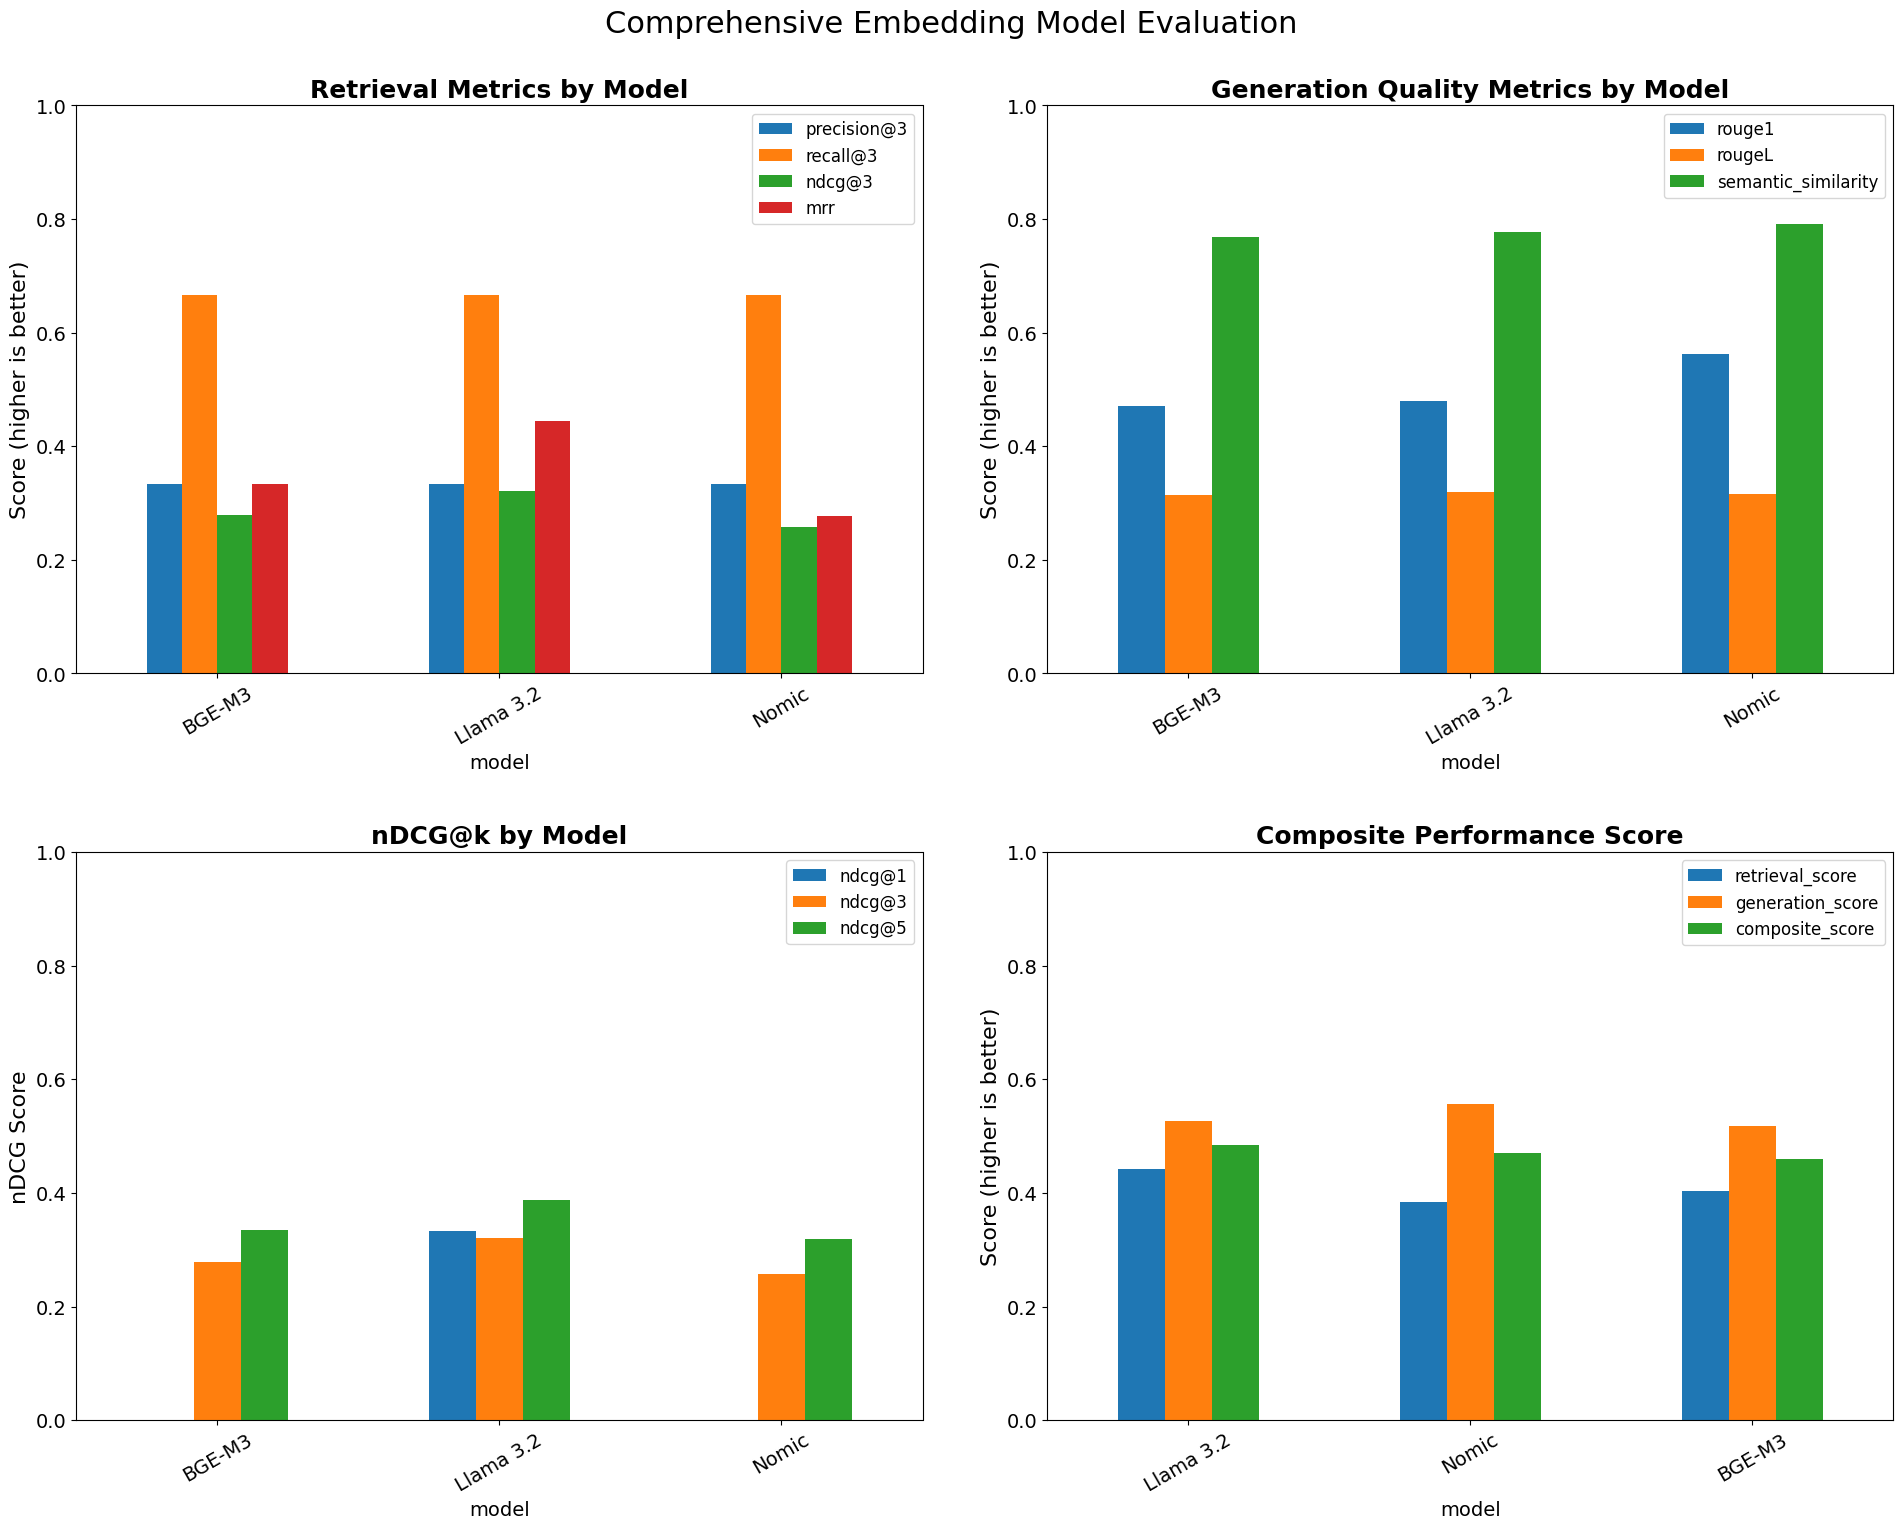

<Figure size 1200x600 with 0 Axes>

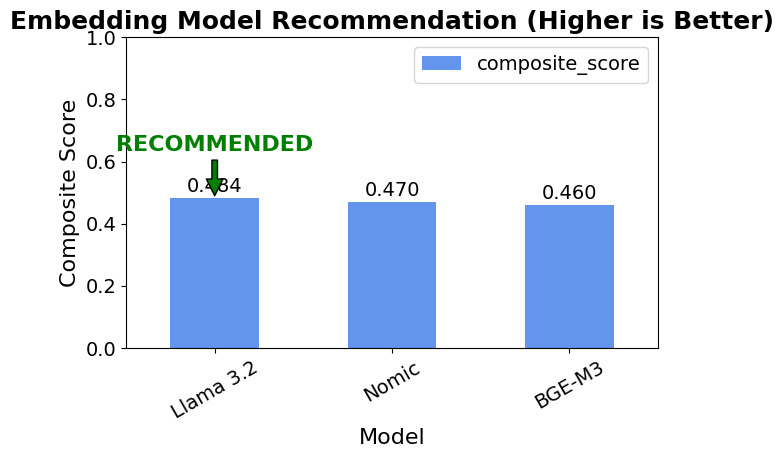

In [18]:
# Create visualizations for comprehensive evaluation
plt.figure(figsize=(20, 16))

# 1. Retrieval Metrics Comparison
plt.subplot(2, 2, 1)
metrics_to_plot = ['precision@3', 'recall@3', 'ndcg@3', 'mrr']
model_avg_metrics = retrieval_df.groupby('model')[metrics_to_plot].mean()
model_avg_metrics.plot(kind='bar', ax=plt.gca())
plt.title('Retrieval Metrics by Model', fontsize=18, fontweight='bold')
plt.ylabel('Score (higher is better)', fontsize=16)
plt.xticks(rotation=30, fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0, 1.0)

# 2. Generation Metrics Comparison
plt.subplot(2, 2, 2)
gen_metrics_to_plot = ['rouge1', 'rougeL', 'semantic_similarity']
model_avg_gen = generation_df.groupby('model')[gen_metrics_to_plot].mean()
model_avg_gen.plot(kind='bar', ax=plt.gca())
plt.title('Generation Quality Metrics by Model', fontsize=18, fontweight='bold')
plt.ylabel('Score (higher is better)', fontsize=16)
plt.xticks(rotation=30, fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0, 1.0)

# 3. nDCG@k for different k values
plt.subplot(2, 2, 3)
ndcg_cols = [col for col in retrieval_df.columns if col.startswith('ndcg@')]
model_ndcg = retrieval_df.groupby('model')[ndcg_cols].mean()
model_ndcg.plot(kind='bar', ax=plt.gca())
plt.title('nDCG@k by Model', fontsize=18, fontweight='bold')
plt.ylabel('nDCG Score', fontsize=16)
plt.xticks(rotation=30, fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0, 1.0)

# 4. Composite Score (weighted average of retrieval and generation)
plt.subplot(2, 2, 4)

# Calculate composite scores
composite_scores = []
for model in retrieval_df['model'].unique():
    # Get retrieval metrics
    r_metrics = retrieval_df[retrieval_df['model'] == model][['precision@3', 'recall@3', 'ndcg@3', 'mrr']].mean()

    # Get generation metrics if available
    if model in generation_df['model'].values:
        g_metrics = generation_df[generation_df['model'] == model][['rouge1', 'rougeL', 'semantic_similarity']].mean()

        # Compute composite score (0.5 * retrieval + 0.5 * generation)
        retrieval_score = 0.25 * (r_metrics['precision@3'] + r_metrics['recall@3'] + r_metrics['ndcg@3'] + r_metrics['mrr'])
        generation_score = (g_metrics['rouge1'] + g_metrics['rougeL'] + g_metrics['semantic_similarity']) / 3
        composite = 0.5 * retrieval_score + 0.5 * generation_score
    else:
        # Only retrieval score
        retrieval_score = 0.25 * (r_metrics['precision@3'] + r_metrics['recall@3'] + r_metrics['ndcg@3'] + r_metrics['mrr'])
        generation_score = 0
        composite = retrieval_score

    composite_scores.append({
        'model': model,
        'retrieval_score': retrieval_score,
        'generation_score': generation_score,
        'composite_score': composite
    })

composite_df = pd.DataFrame(composite_scores)
composite_df.set_index('model')[['retrieval_score', 'generation_score', 'composite_score']].plot(kind='bar', ax=plt.gca())
plt.title('Composite Performance Score', fontsize=18, fontweight='bold')
plt.ylabel('Score (higher is better)', fontsize=16)
plt.xticks(rotation=30, fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0, 1.0)

plt.tight_layout(pad=3.0)
plt.suptitle('Comprehensive Embedding Model Evaluation', fontsize=22, y=0.98)
plt.subplots_adjust(top=0.92)
plt.show()

# Create a final recommendation visualization
plt.figure(figsize=(12, 6))
composite_df = composite_df.sort_values('composite_score', ascending=False)
ax = composite_df.plot(x='model', y='composite_score', kind='bar', color='cornflowerblue')
plt.title('Embedding Model Recommendation (Higher is Better)', fontsize=18, fontweight='bold')
plt.ylabel('Composite Score', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.xticks(rotation=30, fontsize=14)
plt.ylim(0, 1.0)

# Add value labels
for i, v in enumerate(composite_df['composite_score']):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=14)

# Add a "RECOMMENDED" annotation to the best model
best_model_idx = composite_df['composite_score'].idxmax()
best_model = composite_df.loc[best_model_idx, 'model']
best_score = composite_df.loc[best_model_idx, 'composite_score']
plt.annotate('RECOMMENDED',
             xy=(0, best_score),
             xytext=(0, best_score + 0.15),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=16, fontweight='bold', color='green',
             ha='center')

plt.tight_layout()
plt.show()

## Conclusion and Model Selection

After comprehensive evaluation of the embedding models using both retrieval and generation metrics, we can make an informed decision about which model performs best for our specific RAG application.

The evaluation included:

1. **Retrieval Performance**
   - Precision@K and Recall@K
   - Mean Reciprocal Rank (MRR)
   - Normalized Discounted Cumulative Gain (nDCG)

2. **Generation Quality**
   - ROUGE scores for text similarity
   - BLEU score for n-gram precision
   - Semantic similarity using sentence embeddings
   - Exact match for factual accuracy

The composite score combines these metrics to provide a single measure of overall performance, helping us select the most effective embedding model for our RAG system.

Based on this comprehensive evaluation, the recommended embedding model can be integrated into production systems with confidence in its performance.